In [0]:
from sklearn import metrics
from tqdm import tqdm
import pandas as pd
import json
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay
from matplotlib import pyplot as plt

class EvalPipeline:
  """
    This class serves to gather predictions from a model on a datasets, then evaluates 
  """
  def __init__(self, model, dataset=None, dataset_collate_fn=None):
    self.model = model
    self.subgroup_cols = ['STATIC_DEMO_bene_age', 'STATIC_DEMO_sex_label', 'STATIC_DEMO_state_cd', 'STATIC_DEMO_race_label', 'STATIC_DEMO_crec_label', 'STATIC_DEMO_RUCA1']
    self.brier_scores = {subgroup: {} for subgroup in self.subgroup_cols}
    self.preds = []
    self.dataset = dataset
    self.convert_row_to_model_input = dataset_collate_fn
    self.ground_truth_column_name = "target" if "target" in self.dataset.columns else "labels"

  def run_model(self):
    print(f"Total len of dataset: {len(self.dataset)}")
    for idx, data in tqdm(self.dataset.iterrows()):
      x, y = self.convert_row_to_model_input(data)
      preds = self.model.forward(x)
      self.preds.append(float(preds))
    
  def amend_predictions_to_data(self):
    self.dataset["preds"] = self.preds
    self.dataset.to_csv("eval_outputs.csv", index=False)
      
  def evaluate_bias(self):
    brier_scores = {}
    for col in self.dataset.columns:
      if "STATIC" in col:
        cur_df = self.dataset[self.dataset[col] == 1]
        if len(cur_df) > 0:
          preds = cur_df["preds"].to_numpy()
          labels = cur_df[self.ground_truth_column_name].to_numpy()
          brier_score = metrics.brier_score_loss(labels, preds)
    #       f1 = metrics.f1_score(labels,np.rint(preds))
    #       precision = metrics.precision_score(labels, np.rint(preds))
    #       recall = metrics.precision_score(labels, np.rint(preds))
          brier_scores[col] = brier_score
        else:
          print(f"no positive examples for {col}")
      
    preds = self.dataset["preds"].to_numpy()
    labels = self.dataset[self.ground_truth_column_name].to_numpy()
    full_brier_score = metrics.brier_score_loss(labels, preds)
    normalized_dict = {}
    for key in brier_scores:
      normalized_dict[f"{key}_normalized"] = brier_scores[key]/full_brier_score
    brier_scores["all"] = full_brier_score
    brier_scores.update(normalized_dict)
    self.brier_scores = brier_scores

  def save_report(self):
    self.dataset.to_csv("dataset_with_predictions.csv")
    with open('brier_scores.json', 'w') as fp:
      json.dump(self.brier_scores, fp)
    print("yo we saved the report we rule!!")
  
  def plot_pr_curve(self):
    y_true = self.dataset[self.ground_truth_column_name]
    preds = self.dataset['preds']

    precision, recall, thresholds = precision_recall_curve(y_true,preds )
    
    print("Precision, Recall, Threshold")
    for p,r,t in zip(precision, recall, thresholds):
      print(f"{p},{r},{t}")
    plt.plot( recall,precision)
    plt.title("Precision Recall Curve")
    plt.ylabel("precision")
    plt.xlabel("recall")
    
  def confusion_matrix(self,threshold = None):
    y_true = self.dataset[self.ground_truth_column_name]
    preds = self.dataset['preds']
    confusion_matrix = metrics.confusion_matrix(y_true, preds>np.percentile(preds,0.99))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
    disp.plot()
    plt.show()
    
  def error_analysis(self):
    df = self.dataset
    df_pos = df[df["target"] == 1]
    self.correlations = df_pos.corr()['preds'].sort_values().dropna()
    print(self.correlations)
    
    for idx, c in self.correlations.items():
      print(idx, c)
      
  def run(self):
#     self.init_data()
    self.run_model()
    self.amend_predictions_to_data()
    self.evaluate_bias()
    self.save_report()

In [0]:
try:
    import pytorch_lightning as pl
except:
    !pip config --user set global.index-url https://pypi.ccwdata.org/simple
    !pip install pytorch-lightning
    import pytorch_lightning as pl

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://pypi.ccwdata.org/simple
Collecting pytorch-lightning
 Downloading https://pypi.ccwdata.org/packages/bf/c4/955c35600631894e5a44d2e297367bc6d468062e5fef668c2d11fb354f53/pytorch_lightning-1.6.3-py3-none-any.whl (584 kB)
▋ | 10 kB 61.8 MB/s eta 0:00:01 |█▏ | 20 kB 66.9 MB/s eta 0:00:01 |█▊ | 30 kB 76.7 MB/s eta 0:00:01 |██▎ | 40 kB 84.2 MB/s eta 0:00:01 |██▉ | 51 kB 35.7 MB/s eta 0:00:01 |███▍ | 61 kB 40.9 MB/s eta 0:00:01 |████ | 71 kB 45.1 MB/s eta 0:00:01 |████▌ | 81 kB 49.0 MB/s eta 0:00:01 |█████ | 92 kB 53.0 MB/s eta 0:00:01 |█████▋ | 102 kB 56.7 MB/s eta 0:00:01 |██████▏ | 112 kB 56.7 MB/s eta 0:00:01 |██████▊ | 122 kB 56.7 MB/s eta 0:00:01 |███████▎ | 133 kB 56.7 MB/s eta 0:00:01 |███████▉ | 143 kB 56.7 MB/s eta 0:00:01 |████████▍ | 153 kB 56.7 MB/s eta 0:00:01 |█████████ | 163 kB 56.7 MB/s eta 0:00:01 |█████████▌ | 174 kB 56.7 MB/s eta 0:00:01 |██████████ | 184 kB 56.7 MB/s eta 0:00:01 |██████████▋ | 194 kB 56.7 MB/s eta 0:00:01 |███████████▏ | 204 kB 56.7 MB/s eta 0:00:01 |███████████▉ | 215 kB 56.7 MB/s eta 0:00:01 |████████████▍ | 225 kB 56.7 MB/s eta 0:00:01 |█████████████ | 235 kB 56.7 MB/s eta 0:00:01 |█████████████▌ | 245 kB 56.7 MB/s eta 0:00:01 |██████████████ | 256 kB 56.7 MB/s eta 0:00:01 |██████████████▋ | 266 kB 56.7 MB/s eta 0:00:01 |███████████████▏ | 276 kB 56.7 MB/s eta 0:00:01 |███████████████▊ | 286 kB 56.7 MB/s eta 0:00:01 |████████████████▎ | 296 kB 56.7 MB/s eta 0:00:01 |████████████████▉ | 307 kB 56.7 MB/s eta 0:00:01 |█████████████████▍ | 317 kB 56.7 MB/s eta 0:00:01 |██████████████████ | 327 kB 56.7 MB/s eta 0:00:01 |██████████████████▌ | 337 kB 56.7 MB/s eta 0:00:01 |███████████████████ | 348 kB 56.7 MB/s eta 0:00:01 |███████████████████▋ | 358 kB 56.7 MB/s eta 0:00:01 |████████████████████▏ | 368 kB 56.7 MB/s eta 0:00:01 |████████████████████▊ | 378 kB 56.7 MB/s eta 0:00:01 |█████████████████████▎ | 389 kB 56.7 MB/s eta 0:00:01 |█████████████████████▉ | 399 kB 56.7 MB/s eta 0:00:01 |██████████████████████▍ | 409 kB 56.7 MB/s eta 0:00:01 |███████████████████████ | 419 kB 56.7 MB/s eta 0:00:01 |███████████████████████▋ | 430 kB 56.7 MB/s eta 0:00:01 |████████████████████████▏ | 440 kB 56.7 MB/s eta 0:00:01 |████████████████████████▊ | 450 kB 56.7 MB/s eta 0:00:01 |█████████████████████████▎ | 460 kB 56.7 MB/s eta 0:00:01 |█████████████████████████▉ | 471 kB 56.7 MB/s eta 0:00:01 |██████████████████████████▍ | 481 kB 56.7 MB/s eta 0:00:01 |███████████████████████████ | 491 kB 56.7 MB/s eta 0:00:01 |███████████████████████████▌ | 501 kB 56.7 MB/s eta 0:00:01 |████████████████████████████ | 512 kB 56.7 MB/s eta 0:00:01 |████████████████████████████▋ | 522 kB 56.7 MB/s eta 0:00:01 |█████████████████████████████▏ | 532 kB 56.7 MB/s eta 0:00:01 |█████████████████████████████▊ | 542 kB 56.7 MB/s eta 0:00:01 |██████████████████████████████▎ | 552 kB 56.7 MB/s eta 0:00:01 |██████████████████████████████▉ | 563 kB 56.7 MB/s eta 0:00:01 |███████████████████████████████▍| 573 kB 56.7 MB/s eta 0:00:01 |████████████████████████████████| 583 kB 56.7 MB/s eta 0:00:01 |████████████████████████████████| 584 kB 56.7 MB/s 
Requirement already satisfied: numpy>=1.17.2 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (1.20.1)
Collecting torchmetrics>=0.4.1
 Downloading https://pypi.ccwdata.org/packages/5b/bd/4d55ca67c0dfc79b882fd5175da35f9cee359a173776c85f1ecadb7e9d84/torchmetrics-0.8.2-py3-none-any.whl (409 kB)
▉ | 10 kB 64.2 MB/s eta 0:00:01 |█▋ | 20 kB 73.8 MB/s eta 0:00:01 |██▍ | 30 kB 82.9 MB/s eta 0:00:01 |███▏ | 40 kB 90.4 MB/s eta 0:00:01 |████ | 51 kB 97.2 MB/s eta 0:00:01 |████▉ | 61 kB 103.0 MB/s eta 0:00:01 |█████▋ | 71 kB 106.8 MB/s eta 0:00:01 |██████▍ | 81 kB 109.6 MB/s eta 0:00:01 |███████▏ | 92 kB 112.6 MB/s eta 0:00:01 |████████ | 102 kB 115.7 MB/s eta 0:00:01 |████████▉ | 112 kB 115.7 MB/s eta 0:00:01 |█████████▋ | 122 kB 115.7 MB/s e

In [0]:
%run ./utils/model_setup

In [0]:
%run ./utils/dataloader_setup

In [0]:
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/ee87f388c3244c44a7361a86f52168a3/epoch=6-step=24976.ckpt"
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/38509948b29348a88d6daf84c07929d4/epoch=1-step=3568.ckpt"
#resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/c198121ba8ad4d57b3c5e1ca39ad9618/epoch=26-step=48168.ckpt"
#resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/b4426b6e19ce46029e14fc8f5d0347d2/epoch=6-step=12488.ckpt"



#no predictions
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/1ff1d49022724dde98d8007cee634afc/epoch=20-step=18795.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128, 64, 32, 16, 8, 4], input_size = 149)

# F1-score 0.011
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/0454a985a5b44844a175d9eff544d531/epoch=19-step=17900.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128,128,128, 64, 32, 16, 8, 4], input_size = 349)

# F1-score 0.002
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/ef0fec0e56374ebaa69c2a16ce6b2f9a/epoch=9-step=8950.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128,128,128, 64, 32, 16, 8, 4], input_size = 349)

# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/ef0fec0e56374ebaa69c2a16ce6b2f9a/epoch=9-step=8950.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128,128,128, 64, 32, 16, 8, 4], input_size = 349)

# F1-score 0.01
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/29a863e8d3c94abcb2f7a7f39c91a931/epoch=19-step=17900.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128, 64, 32, 16, 8, 4], input_size = 349)

#no predictions
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/4bc34e93b15944f18b071db6b50a993d/epoch=29-step=26850.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCELoss(), layer_sizes = [128,128,128, 64, 32, 16, 8, 4], input_size = 349)

#no predictions
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/1ff1d49022724dde98d8007cee634afc/epoch=20-step=18795.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128, 64, 32, 16, 8, 4], input_size = 149)

# max - idk what this one resulted in
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/84fa99cf5ed147d48ff28939ce0fab12/epoch=6-step=6265.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [256, 256, 128, 128, 128, 64, 32, 16, 8, 4], input_size = 349)

# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/644d70cabaa04776948bfc75225a0166/epoch=13-step=12530.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([45])), layer_sizes = [128, 128, 128, 64, 32, 16, 8, 4], input_size = 349)

# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/09fa125bfe884d9e8e88ffe98367d56d/epoch=49-step=89250.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=150, layer_sizes=[128,64,4])

#Average precision = 0.0034
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/93ea04d95ea645228f5fd4ffd29aff59/epoch=29-step=9600.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=[128, 128, 128, 64, 32, 16, 3])

# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/ac50cfc2abf54fc3883b5c499d856046/epoch=36-step=11840.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=[128, 128, 128, 64, 32, 16, 3])

# strong model from expt 1
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/167b9bcfd82e47c38712a4ceb6792b1b/epoch=49-step=8000.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([13.338265419006348])),layer_sizes=[192, 192, 128, 128, 64, 32, 16, 3])

# PR_AUC = 0.0037
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/d8822bdb41cc41739c92034a701b3b7c/epoch=28-step=4640.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=[128, 128, 128, 128, 128, 64, 32, 16, 3])

#best thus far 3:22pm 7/26
# PR = 0.0052
resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/167b9bcfd82e47c38712a4ceb6792b1b/epoch=49-step=8000.ckpt"
model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=	[192, 192, 128, 128, 64, 32, 16, 3])

# PR = 0.0033
# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/460ef6fe6d184796aab4b33e52c103ce/epoch=49-step=8000-v1.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=	[128, 128, 128, 128, 64, 32, 16, 3])

# resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/460ef6fe6d184796aab4b33e52c103ce/epoch=20-step=3360-v1.ckpt"
# model = BasicMLP.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=	[128, 128, 128, 128, 64, 32, 16, 3])

def dataset_collate_fn(row):
  if "labels" in row.index:
    target_col = "labels"
  else:
    target_col = "target"
  y = row[target_col]
  row.drop(labels=[target_col], inplace=True)
  x = torch.Tensor(row.to_numpy())
  return x, y

Layer 1 created with dimensions 192,192
Layer 2 created with dimensions 192,128
Layer 3 created with dimensions 128,128
Layer 4 created with dimensions 128,64
Layer 5 created with dimensions 64,32
Layer 6 created with dimensions 32,16
Layer 7 created with dimensions 16,3

In [0]:
# from torch.utils.data import DataLoader
# preds = []
# labels = []
# dataset = CMSPytorchDataset(csv_path="/dbfs/mnt/eldb_mnt/MMA394/data/test_ts_data.csv")
# dataloader = DataLoader(dataset, batch_size = 32,num_workers = 4)
# for input, label in dataloader:
# #  print(input.shape)
#   preds.extend(model.forward(input.float()).detach().numpy())
#   labels.extend(label.numpy())
# #  print(pred.shape)

# preds = np.array(preds).ravel()
# labels = np.array(labels).ravel()

In [0]:

# preds_disc = preds
# thresh = 0.97
# print(f"Mean prediction is {np.mean(preds)}")
# preds_disc[preds_disc>=thresh] = 1
# preds_disc[preds_disc<thresh] = 0

# print(metrics.classification_report(labels, preds_disc))
# print(metrics.f1_score(labels, preds_disc, average = "binary"))

# plt.hist(preds, bins = 100)

# confusion_matrix = metrics.confusion_matrix(labels, preds>=thresh)
# disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
# disp.plot()
# plt.show()

# precision, recall, thresholds = precision_recall_curve(labels,preds )
# plt.plot( recall,precision)
# plt.title("PR Curve")
# plt.ylabel("precision")
# plt.xlabel("recall")

In [0]:
dataset = CMSPytorchDataset(csv_path="/dbfs/mnt/eldb_mnt/MMA394/data/eval_ts_abr.csv", one_hot_encoding=True)
full_df = dataset.get_full_dataset_as_df()
# full_df = full_df.drop(["bene_id"],axis=1)
#full_df = full_df.head(100000)
model.eval()
eval_pipeline = EvalPipeline(model, dataset=full_df, dataset_collate_fn = dataset_collate_fn)
eval_pipeline.run()

True
Total len of dataset: 196315
0it [00:00, ?it/s]1it [00:00, 3.07it/s]53it [00:00, 160.11it/s]107it [00:00, 274.24it/s]162it [00:00, 356.31it/s]213it [00:00, 400.51it/s]266it [00:00, 438.47it/s]316it [00:00, 450.66it/s]376it [00:01, 492.47it/s]434it [00:01, 516.97it/s]492it [00:01, 534.97it/s]548it [00:01, 540.22it/s]608it [00:01, 556.91it/s]667it [00:01, 565.13it/s]725it [00:01, 562.52it/s]782it [00:01, 562.27it/s]839it [00:01, 556.82it/s]895it [00:01, 557.56it/s]957it [00:02, 574.89it/s]1018it [00:02, 574.96it/s]1077it [00:02, 579.20it/s]1136it [00:02, 580.19it/s]1197it [00:02, 588.53it/s]1258it [00:02, 594.84it/s]1318it [00:02, 589.69it/s]1378it [00:02, 589.21it/s]1440it [00:02, 597.56it/s]1502it [00:02, 601.15it/s]1563it [00:03, 589.89it/s]1623it [00:03, 591.07it/s]1685it [00:03, 598.26it/s]1745it [00:03, 591.49it/s]1805it [00:03, 588.67it/s]1865it [00:03, 590.52it/s]1926it [00:03, 595.70it/s]1987it [00:03, 599.34it/s]2047it [00:03, 594.33it/s]2108it [00:03, 597.46it/s]2170it [00:04, 604.14it/s]2233it [00:04, 610.19it/s]2296it [00:04, 613.69it/s]2358it [00:04, 614.07it/s]2421it [00:04, 616.13it/s]2483it [00:04, 615.07it/s]2545it [00:04, 610.08it/s]2607it [00:04, 608.27it/s]2668it [00:04, 608.56it/s]2730it [00:05, 609.75it/s]2791it [00:05, 605.29it/s]2854it [00:05, 609.99it/s]2916it [00:05, 602.57it/s]2978it [00:05, 606.99it/s]3041it [00:05, 612.18it/s]3104it [00:05, 616.55it/s]3168it [00:05, 622.19it/s]3232it [00:05, 626.12it/s]3296it [00:05, 629.09it/s]3360it [00:06, 631.42it/s]3424it [00:06, 632.90it/s]3488it [00:06, 620.48it/s]3551it [00:06, 603.73it/s]3612it [00:06, 601.74it/s]3673it [00:06, 602.38it/s]3734it [00:06, 601.39it/s]3795it [00:06, 603.12it/s]3856it [00:06, 604.94it/s]3917it [00:06, 605.33it/s]3978it [00:07, 606.23it/s]4039it [00:07, 594.89it/s]4099it [00:07, 586.36it/s]4158it [00:07, 575.86it/s]4221it [00:07, 588.79it/s]4280it [00:07, 564.86it/s]4337it [00:07, 566.15it/s]4395it [00:07, 566.73it/s]4452it [00:07, 560.56it/s]4509it [00:07, 548.21it/s]4565it [00:08, 551.31it/s]4621it [00:08, 545.03it/s]4676it [00:08, 542.41it/s]4731it [00:08, 539.19it/s]4789it [00:08, 550.76it/s]4847it [00:08, 556.76it/s]4903it [00:08, 554.71it/s]4960it [00:08, 558.04it/s]5020it [00:08, 565.18it/s]5077it [00:09, 560.63it/s]5136it [00:09, 566.96it/s]5197it [00:09, 570.67it/s]5255it [00:09, 569.93it/s]5312it [00:09, 542.77it/s]5368it [00:09, 545.18it/s]5423it [00:09, 539.82it/s]5479it [00:09, 545.06it/s]5537it [00:09, 554.24it/s]5594it [00:09, 556.76it/s]5651it [00:10, 558.04it/s]5707it [00:10, 546.32it/s]5768it [00:10, 563.64it/s]5825it [00:10, 557.45it/s]5883it [00:10, 563.26it/s]5942it [00:10, 568.74it/s]5999it [00:10, 563.60it/s]6056it [00:10, 547.60it/s]6113it [00:10, 553.74it/s]6169it [00:10, 534.14it/s]6223it [00:11, 529.45it/s]6281it [00:11, 542.25it/s]6336it [00:11, 524.89it/s]6395it [00:11, 541.22it/s]6450it [00:11, 541.70it/s]6505it [00:11, 539.59it/s]6560it [00:11, 523.95it/s]6614it [00:11, 528.35it/s]6667it [00:11, 513.21it/s]6719it [00:12, 511.94it/s]6771it [00:12, 510.14it/s]6823it [00:12, 493.49it/s]6877it [00:12, 505.56it/s]6928it [00:12, 504.56it/s]6986it [00:12, 525.77it/s]7039it [00:12, 526.43it/s]7093it [00:12, 528.70it/s]7146it [00:12, 513.21it/s]7198it [00:12, 511.57it/s]7253it [00:13, 522.19it/s]7308it [00:13, 528.44it/s]7361it [00:13, 528.17it/s]7414it [00:13, 516.20it/s]7469it [00:13, 523.90it/s]7522it [00:13, 519.68it/s]7578it [00:13, 524.29it/s]7632it [00:13, 527.36it/s]7688it [00:13, 535.68it/s]7745it [00:14, 544.46it/s]7800it [00:14, 544.42it/s]7855it [00:14, 530.96it/s]7914it [00:14, 547.84it/s]7973it [00:14, 559.48it/s]8033it [00:14, 569.50it/s]8091it [00:14, 570.54it/s]8149it [00:14, 567.98it/s]8206it [00:14, 554.74it/s]8262it [00:14, 538.80it/s]8317it [00:15, 514.73it/s]8369it [00:15, 515.63it/s]8421it [00:15, 515.16it/s]8476it [00:15, 522.88it/s]

Precision, Recall, Threshold
0.0022540095361941914,1.0,0.04908560961484909
0.00224505832049228,0.995475113122172,0.049085620790719986
0.0022459980398562562,0.995475113122172,0.04908563196659088
0.002247294308727163,0.995475113122172,0.04908563941717148
0.0022485690923957483,0.995475113122172,0.04908565431833267
0.002241142880533781,0.9909502262443439,0.04908566549420357
0.002241647559777268,0.9909502262443439,0.04908567667007446
0.002242014742014742,0.9909502262443439,0.04908568784594536
0.002242370564534708,0.9909502262443439,0.049085699021816254
0.0022426116697728715,0.9909502262443439,0.04908571019768715
0.0022326229222780947,0.9864253393665159,0.049085717648267746
0.002227855880771299,0.9841628959276018,0.04908573254942894
0.0022280498673413985,0.9841628959276018,0.049085743725299835
0.002228369448286461,0.9841628959276018,0.04908575490117073
0.002228654865896457,0.9841628959276018,0.049085766077041626
0.002223782171825602,0.9819004524886877,0.04908577725291252
0.002224032878790208,0.9819004524886877,0.04908578842878342
0.0022243976443936464,0.9819004524886877,0.049085795879364014
0.002224694104560623,0.9819004524886877,0.04908581078052521
0.002224876580867087,0.9819004524886877,0.049085818231105804
0.002225036272192686,0.9819004524886877,0.049085833132267
0.0022252986719991795,0.9819004524886877,0.049085844308137894
0.0022255611337028925,0.9819004524886877,0.04908585548400879
0.0022257551669316376,0.9819004524886877,0.049085866659879684
0.002226063406902848,0.9819004524886877,0.04908587411046028
0.0022263032081337015,0.9819004524886877,0.049085889011621475
0.0022214127774842114,0.9796380090497737,0.04908589646220207
0.0022216977259666695,0.9796380090497737,0.049085911363363266
0.00222188013136289,0.9796380090497737,0.04908592253923416
0.002222153795623435,0.9796380090497737,0.04908592998981476
0.002222370494310629,0.9796380090497737,0.04908594489097595
0.0022226328703275947,0.9796380090497737,0.04908595234155655
0.0022228610737497047,0.9796380090497737,0.04908596724271774
0.002223123565623219,0.9796380090497737,0.04908597469329834
0.002223306205232215,0.9796380090497737,0.049085989594459534
0.0022235573836997323,0.9796380090497737,0.04908600077033043
0.002223808618927539,0.9796380090497737,0.049086008220911026
0.0022240599109348757,0.9796380090497737,0.04908602312207222
0.002219151482773323,0.9773755656108597,0.04908603057265282
0.0022194593150501947,0.9773755656108597,0.04908604547381401
0.0022196531791907515,0.9773755656108597,0.04908605292439461
0.002214719922716038,0.9751131221719457,0.0490860678255558
0.0022149134076776813,0.9751131221719457,0.0490860790014267
0.0022151638501706344,0.9751131221719457,0.049086086452007294
0.002215334638890174,0.9751131221719457,0.04908610135316849
0.0022155965660823522,0.9751131221719457,0.049086108803749084
0.0022158585552190923,0.9751131221719457,0.04908612370491028
0.002216211769061478,0.9751131221719457,0.049086131155490875
0.0022164625052711697,0.9751131221719457,0.04908614233136177
0.0022116724873086,0.9728506787330317,0.049086157232522964
0.0022124690640226803,0.9728506787330317,0.04908616468310356
0.0022127536947840762,0.9728506787330317,0.049086179584264755
0.0022131864738277832,0.9728506787330317,0.04908618703484535
0.0022136764016947494,0.9728506787330317,0.049086201936006546
0.0022139499441363795,0.9728506787330317,0.04908620938658714
0.0022144630184675915,0.9728506787330317,0.04908622056245804
0.0022147937923965616,0.9728506787330317,0.04908623546361923
0.0022156725339049425,0.9728506787330317,0.04908624291419983
0.0022159579895592303,0.9728506787330317,0.04908625781536102
0.002211214828025215,0.9705882352941176,0.04908626526594162
0.002211534000402097,0.9705882352941176,0.049086280167102814
0.0022119445003016287,0.9705882352941176,0.04908628761768341
0.0022127545441416163,0.9705882352941176,0.049086298793554306
0.0022150852988557976,0.9705882352941176,0.0490863099694252
0.0022155200016526024,0.9705882352941176,0.0490863211452961
0.0022159434288754475,0.9705882352941176,0

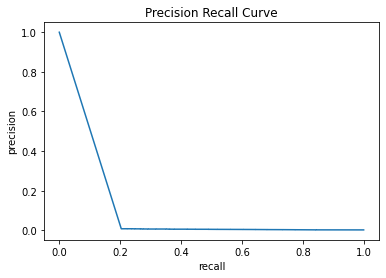

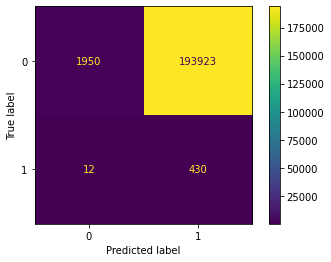

Out[58]:

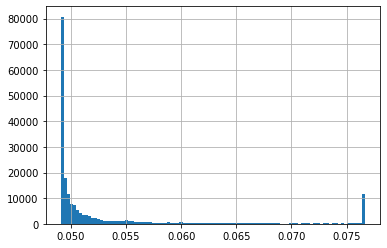

<AxesSubplot:>

In [0]:
eval_pipeline.plot_pr_curve()
eval_pipeline.confusion_matrix()
eval_pipeline.dataset["preds"].hist(bins=100)


In [0]:
df = eval_pipeline.dataset
trues = eval_pipeline.dataset['target'].to_numpy()
preds = eval_pipeline.dataset['preds'].to_numpy()

preds_disc = preds.copy()
thresh = np.percentile(preds,0.99)
#thresh = 0.4980
preds_disc[preds_disc>thresh] = 1
preds_disc[preds_disc<=thresh] = 0

print(metrics.classification_report(trues, preds_disc))
print(metrics.f1_score(trues, preds_disc, average = "binary"))
print(metrics.average_precision_score(trues, preds, average = None))

precision recall f1-score support

 0.0 0.99 0.01 0.02 195873
 1.0 0.00 0.97 0.00 442

 accuracy 0.01 196315
 macro avg 0.50 0.49 0.01 196315
weighted avg 0.99 0.01 0.02 196315

0.004414897712980312
0.005244554813707478

In [0]:
eval_pipeline.brier_scores

Out[61]: {'STATIC_DEMO_sex_label_female': 0.004817397955242655,
 'STATIC_DEMO_sex_label_male': 0.0048883414079538045,
 'STATIC_DEMO_state_cd_sc': 0.0038459579440222494,
 'STATIC_DEMO_state_cd_az': 0.006004999844709878,
 'STATIC_DEMO_state_cd_la': 0.003128308474061228,
 'STATIC_DEMO_state_cd_mn': 0.006520513366931196,
 'STATIC_DEMO_state_cd_nj': 0.004569001698858249,
 'STATIC_DEMO_state_cd_dc': 0.0026476904612547755,
 'STATIC_DEMO_state_cd_or': 0.007080293788781657,
 'STATIC_DEMO_state_cd_va': 0.004193322985252722,
 'STATIC_DEMO_state_cd_ri': 0.004985742512208018,
 'STATIC_DEMO_state_cd_ky': 0.00588381949528014,
 'STATIC_DEMO_state_cd_wy': 0.0028517316720701965,
 'STATIC_DEMO_state_cd_nh': 0.007997192134583097,
 'STATIC_DEMO_state_cd_mi': 0.005612356840593166,
 'STATIC_DEMO_state_cd_nv': 0.005593828338145544,
 'STATIC_DEMO_state_cd_wi': 0.004901961489169128,
 'STATIC_DEMO_state_cd_id': 0.0048361161732873754,
 'STATIC_DEMO_state_cd_ca': 0.005633745400427486,
 'STATIC_DEMO_state_cd_ct': 0.004929830777756235,
 'STATIC_DEMO_state_cd_ne': 0.005124052216308372,
 'STATIC_DEMO_state_cd_mt': 0.004374726483459214,
 'STATIC_DEMO_state_cd_nc': 0.005045326729184279,
 'STATIC_DEMO_state_cd_vt': 0.004504410761355377,
 'STATIC_DEMO_state_cd_md': 0.004984780884163884,
 'STATIC_DEMO_state_cd_de': 0.005912276816357279,
 'STATIC_DEMO_state_cd_mo': 0.003871669283170935,
 'STATIC_DEMO_state_cd_vi': 0.0024886116629123426,
 'STATIC_DEMO_state_cd_il': 0.003726391466874828,
 'STATIC_DEMO_state_cd_me': 0.004297669150246368,
 'STATIC_DEMO_state_cd_nd': 0.0027333259074715506,
 'STATIC_DEMO_state_cd_wa': 0.005742957665824167,
 'STATIC_DEMO_state_cd_ms': 0.0038466846273199845,
 'STATIC_DEMO_state_cd_al': 0.004425873052757328,
 'STATIC_DEMO_state_cd_in': 0.003654278248078554,
 'STATIC_DEMO_state_cd_oh': 0.0032556114730048244,
 'STATIC_DEMO_state_cd_tn': 0.004296112236462332,
 'STATIC_DEMO_state_cd_ia': 0.003296433080191294,
 'STATIC_DEMO_state_cd_nm': 0.006588913524932501,
 'STATIC_DEMO_state_cd_pa': 0.005528719223762041,
 'STATIC_DEMO_state_cd_sd': 0.003919502126347879,
 'STATIC_DEMO_state_cd_ny': 0.0041217715277434,
 'STATIC_DEMO_state_cd_tx': 0.004249595491504483,
 'STATIC_DEMO_state_cd_wv': 0.002874657662986734,
 'STATIC_DEMO_state_cd_ga': 0.004093444412469934,
 'STATIC_DEMO_state_cd_ma': 0.004924670992963582,
 'STATIC_DEMO_state_cd_ks': 0.004093892349576434,
 'STATIC_DEMO_state_cd_fl': 0.006557149900722643,
 'STATIC_DEMO_state_cd_co': 0.004737247058286745,
 'STATIC_DEMO_state_cd_ak': 0.007602906415237969,
 'STATIC_DEMO_state_cd_ar': 0.0037356700172440547,
 'STATIC_DEMO_state_cd_ok': 0.005355500017371699,
 'STATIC_DEMO_state_cd_pr': 0.0024320174201246706,
 'STATIC_DEMO_state_cd_ut': 0.0053069297578818495,
 'STATIC_DEMO_state_cd_hi': 0.0047372898887222915,
 'STATIC_DEMO_state_cd_unassigned': 0.002827439726974838,
 'STATIC_DEMO_race_label_black_or_african_american': 0.004364220385181212,
 'STATIC_DEMO_race_label_asian__pacific_islander': 0.003338701158340316,
 'STATIC_DEMO_race_label_unknown': 0.0039160589957464124,
 'STATIC_DEMO_race_label_other': 0.005622262553889669,
 'STATIC_DEMO_race_label_hispanic': 0.004760078898044074,
 'STATIC_DEMO_race_label_american_indian__alaska_native': 0.004345388372519146,
 'STATIC_DEMO_race_label_non_hispanic_white': 0.0048962102310608265,
 'STATIC_DEMO_crec_label_old_age_and_survivors_insurance_oasi': 0.004845078713451557,
 'STATIC_DEMO_crec_label_end_stage_renal_disease_esrd': 0.002433809043050554,
 'STATIC_DEMO_crec_label_disability_insurance_benefits_dib': 0.00587969627469237,
 'STATIC_DEMO_RUCA1_1': 0.0049829476144061,
 'STATIC_DEMO_RUCA1_4': 0.005061434252911092,
 'STATIC_DEMO_RUCA1_2': 0.004570837403816605,
 'STATIC_DEMO_RUCA1_7': 0.004699070056187871,
 'STATIC_DEMO_RUCA1_3': 0.0037935636658112232,
 'STATIC_DEMO_RUCA1_9': 0.005119452273778892,
 'STATIC_DEMO_RUCA1_10': 0.0043209942691691365,
 'STATIC_DEMO_RUCA1_8': 0.004617722205398303,
 'STATIC_DEMO_RUCA1_6': 0.00287069965522839,
 'STATIC_DEMO_RUCA1_5': 0.00409109071

In [0]:
df = eval_pipeline.dataset
df_pos = df[df["target"] == 1]
correlations = df_pos.corr()['preds'].sort_values().dropna()

for idx, c in correlations.items():
  print(idx, c)

TS_MME_ALL_SA__count_below__t_89 -0.7118828017022285
TS_MME_ALL_SA__last_location_of_minimum -0.385169858000134
TS_MME_ALL_SA__ratio_beyond_r_sigma__r_5 -0.2829528344960944
TS_MME_ALL_SA__count_below_mean -0.23792715040389076
TS_MME_ALL_SA__ratio_beyond_r_sigma__r_6 -0.2348497678697291
TS_MME_ALL_SA__ratio_beyond_r_sigma__r_7 -0.18024332590207257
TS_MME_ALL_SA__last_location_of_maximum -0.17159505858469867
TS_MME_ALL_SA__first_location_of_maximum -0.15529416484495037
CC_Osteoporosis -0.1388105414534979
CC_Anemia -0.11014067188159557
STATIC_DEMO_state_cd_mn -0.1087299255208317
STATIC_DEMO_sex_label_female -0.10550735348898249
TS_MME_ALL_SA__percentage_of_reoccurring_values_to_all_values -0.1021105811202886
TS_MME_ALL_SA__ratio_beyond_r_sigma__r_10 -0.10061835060580358
TS_MME_ALL_SA__mean_second_derivative_central -0.10046986552039741
CC_Cystic_Fibrs -0.09062117974372327
CC_Breast_Cncr -0.08965711094715637
CC_Hypothyroidism -0.089223705769389
STATIC_DEMO_state_cd_nv -0.08301243439041113
STATIC_DEMO_state_cd_ma -0.0812026455858742
STATIC_DEMO_state_cd_co -0.07782815046633666
STATIC_DEMO_state_cd_ne -0.07624907218169916
CC_Spinal_injury -0.07596981568072199
CC_Alzheimers -0.07016014927469412
STATIC_DEMO_state_cd_id -0.06971540939047585
STATIC_DEMO_state_cd_mo -0.06944656496120638
STATIC_DEMO_ADI_NATRANK_binned_51_60 -0.06818821054974238
STATIC_DEMO_state_cd_ar -0.06764257740741017
STATIC_DEMO_race_label_hispanic -0.06755625591382262
STATIC_DEMO_RUCA1_8 -0.0659303148023944
STATIC_DEMO_state_cd_de -0.06409696353392877
TS_MME_ALL_LA__count_below__t_89 -0.06367164652960937
STATIC_DEMO_state_cd_nc -0.05510968220824434
STATIC_DEMO_race_label_other -0.05391220788447818
STATIC_DEMO_race_label_black_or_african_american -0.053479924240615324
CC_Periph_vasc_dis -0.05229987073100875
STATIC_DEMO_state_cd_mi -0.05050566435256377
STATIC_DEMO_state_cd_tx -0.048864766801964395
STATIC_DEMO_ADI_NATRANK_binned_41_50 -0.048012242368163136
STATIC_DEMO_race_label_unknown -0.04713589930673584
TS_MME_ALL_LA__last_location_of_minimum -0.04661684996138571
STATIC_DEMO_RUCA1_9 -0.04633899074932935
CC_Epilepsy -0.04574326083426699
CC_CHF -0.043532535700406466
CC_Leuk_lymph -0.04310211568788076
CC_Lung_cncr -0.04216208045665136
STATIC_DEMO_state_cd_hi -0.04214690720165626
STATIC_DEMO_race_label_asian__pacific_islander -0.04214690720165626
STATIC_DEMO_state_cd_il -0.04195729602273461
CC_Cataract -0.041535558779999426
STATIC_DEMO_state_cd_wi -0.041325444263683855
TS_MME_ALL_LA__number_peaks__n_3 -0.040051506140668935
TS_MME_ALL_LA__number_peaks__n_50 -0.03718549156289086
CC_PTSD -0.036446721226632485
CC_Mobility_impairment -0.03632852664680116
STATIC_DEMO_ADI_NATRANK_binned_81_90 -0.035783836537001436
STATIC_DEMO_RUCA1_1 -0.03498559098094333
CC_Schizophrenia_and_other_psychotic -0.03430577462723622
CC_Schizophrenia -0.033697283468299616
STATIC_DEMO_state_cd_la -0.03151916103854306
STATIC_DEMO_state_cd_ia -0.03150723971043736
CC_Hyperlipidemia -0.03147524262732798
STATIC_DEMO_state_cd_ri -0.031360337289047004
CC_Glaucoma -0.030560986943242052
STATIC_DEMO_state_cd_ms -0.02806050701455305
STATIC_DEMO_ADI_NATRANK_binned_21_30 -0.024470544657409405
STATIC_DEMO_RUCA1_10 -0.023458160923752518
STATIC_DEMO_state_cd_wa -0.022739809838097202
TS_MME_ALL_LA__ratio_beyond_r_sigma__r_1 -0.02252560188107298
CC_Bipolar -0.02144552758345119
TS_MME_ALL_LA__ratio_beyond_r_sigma__r_5 -0.017046296091909524
TS_MME_ALL_LA__ratio_beyond_r_sigma__r_7 -0.016873503644313177
CC_Alz_Dem -0.014772296006307035
STATIC_DEMO_state_cd_oh -0.014648164447042707
CC_Migraine -0.014308677010506076
CC_Visual_imp -0.014061676762476527
TS_MME_ALL_LA__ratio_value_number_to_time_series_length -0.013947371618650497
TS_MME_ALL_LA__last_location_of_maximum -0.013766889374071521
CC_Ulcers -0.012250890294113005
STATIC_DEMO_state_cd_nm -0.011569490547501532
STATIC_DEMO_ADI_NATRANK_binned_0_10 -0.009934056768737716
TS_MME_ALL_LA__mean_second_derivative_central -0.008983795947103627
STATIC_DEMO_RUCA1_2 -0.0079252390

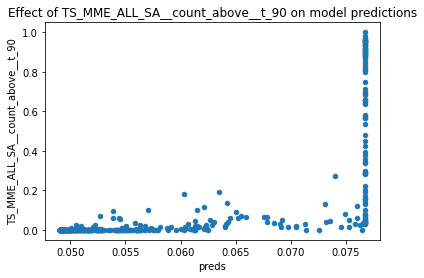

In [0]:
def plot_preds_correlation(df = df_pos,input_var = "TS_MME_ALL_SA__count_above__t_90"):
  df.plot.scatter('preds',input_var, title = f"Effect of {input_var} on model predictions")
  
plot_preds_correlation()

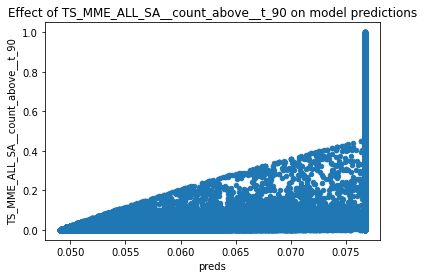

In [0]:
plot_preds_correlation(df,'TS_MME_ALL_SA__count_above__t_90')

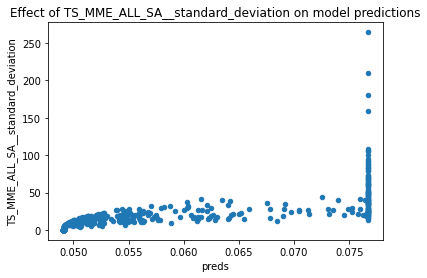

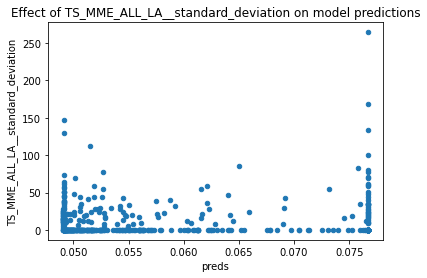

In [0]:
plot_preds_correlation(df_pos,'TS_MME_ALL_SA__standard_deviation') 
plot_preds_correlation(df_pos,'TS_MME_ALL_LA__standard_deviation')

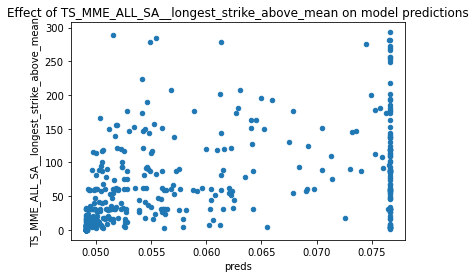

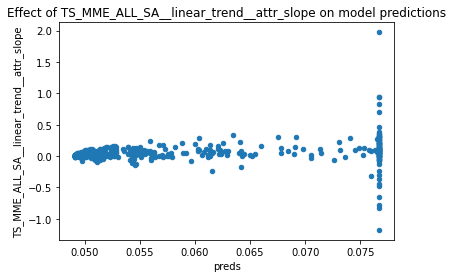

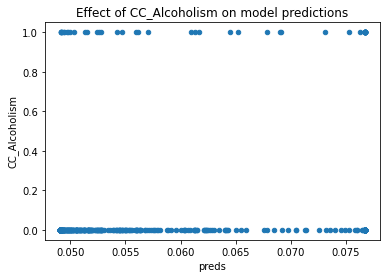

In [0]:
plot_preds_correlation(df_pos,'TS_MME_ALL_SA__longest_strike_above_mean') 
plot_preds_correlation(df_pos,'TS_MME_ALL_SA__linear_trend__attr_slope') 

0.05

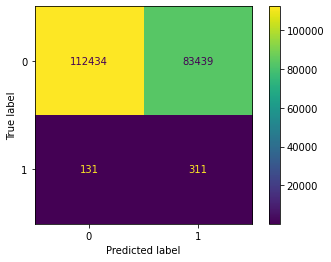

[[112434 83439]
 [ 131 311]]

In [0]:
y_true = eval_pipeline.dataset[eval_pipeline.ground_truth_column_name]
preds = eval_pipeline.dataset['preds']
thresh = 0.05
print(thresh)
confusion_matrix = metrics.confusion_matrix(y_true, preds>thresh)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()
print(confusion_matrix)